In [2]:
'''
# https://www.kalmanfilter.net/alphabeta.html
# Estimate the state of a static system

# Estimate current state
# Predict the next state
'''

import numpy as np
import matplotlib.pyplot as plt
import random
import math
'''
# State Update Equation (estimate of the current state)
# Estimate = Predicted value + kalmangain(measurement - predicted value)
#xEst = xPrev + (1/t)(z-xPrev)

# Estimation Algorithm 
# 0. Initialize - Input: System State and Initial Guess
# 1. Measure - Input: Measured Value
# 2. Update - Calculate the kalman gain then estimate the current state using the state update equation
# Output system state estimate
# 3. Predict -  Calculate the predicted state for the next iteration using the system's dynamic model
'''


"\n# State Update Equation (estimate of the current state)\n# Estimate = Predicted value + kalmangain(measurement - predicted value)\n#xEst = xPrev + (1/t)(z-xPrev)\n\n# Estimation Algorithm \n# 0. Initialize - Input: System State and Initial Guess\n# 1. Measure - Input: Measured Value\n# 2. Update - Calculate the kalman gain then estimate the current state using the state update equation\n# Output system state estimate\n# 3. Predict -  Calculate the predicted state for the next iteration using the system's dynamic model\n"

1: Est x: [977.78120962] Error: [2.22187904]% Measurement err:[2.22187904]% 
2: Est x: [1133.02673367] Error: [13.30267337]% Measurement err:[28.82722577]% 
3: Est x: [1033.69900394] Error: [3.36990039]% Measurement err:[16.49564555]% 
4: Est x: [940.2525677] Error: [5.97474323]% Measurement err:[34.0086741]% 
5: Est x: [910.24215649] Error: [8.97578435]% Measurement err:[20.97994884]% 
6: Est x: [901.64964943] Error: [9.83503506]% Measurement err:[14.13128859]% 
7: Est x: [951.27019406] Error: [4.87298059]% Measurement err:[24.89934619]% 
8: Est x: [858.52744459] Error: [14.14725554]% Measurement err:[79.06718017]% 
9: Est x: [820.9771604] Error: [17.90228396]% Measurement err:[47.94251131]% 
10: Est x: [837.01554873] Error: [16.29844513]% Measurement err:[1.86389563]% 
11: Est x: [827.92319485] Error: [17.20768051]% Measurement err:[26.30003439]% 
12: Est x: [898.85891727] Error: [10.11410827]% Measurement err:[67.91518639]% 
13: Est x: [946.55194828] Error: [5.34480517]% Measurement

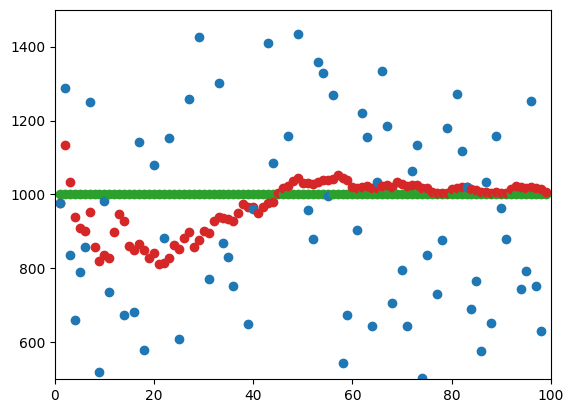

In [10]:
# Example 1: Static State
# Estimating the weight of a gold bar that we know weighs 1000kg 

# True state
x = 1000

# Initial Guess at t=0. initial = x because its not supposed to change
initial = x

# Measured value of the weight at t
z = None

# 1/t calculated each iteration
statemodel = None

# xhat-1
xPrev = None

# Because this example is static, we don't expect it to change
xPrev = initial

# xhat
xEst = None

iterations = 100

plt.axis([0, iterations, x-500, x+500])

for t in range(1, iterations):
    # Weigh and measure
    z = np.random.normal(x, x/2, 1)

    xEst = xPrev + (1/t) * (z - xPrev) 
    xPrev = xEst
    
    plt.scatter(t, x, color="tab:green")
    plt.scatter(t, xEst, color="tab:red")
    plt.scatter(t, z, color="tab:blue")
    
    # Print only the first and last few iterations
    if t < 15 or t > iterations-5:
        print(f"{t}: Est x: {xEst} Error: {(abs(xEst-x)/x)*100}% Measurement err:{(abs(z-x)/x)*100}% ")

plt.show()

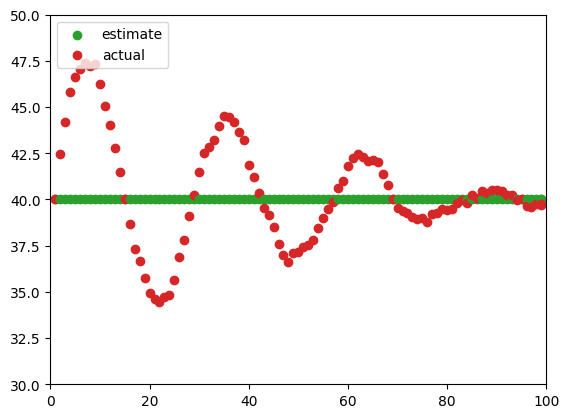

In [31]:
'''
Example 2 - Tracking the Constant Velocity Aircraft in 1D

Aircraft moving away from a radar orthogonally at constant velocity
radar -------> plane

Aircraft state: xdot = v = dx/dt



Prediction Equations (2nd of the 5 KF equations)

xEst = xPrev + xdotPrev*deltaT

and

xdotEst = xdotPrev

because the velocity is constant



Scenario Constants:

deltaT = 5 sec
xPrev = 30,000 m
xdotPrev = 40 m/s

Plugging this into the prediction equations we can predict the position at time t

xEst = 30,000 + 40*5 = 30,200 m
and
xdotEst = 40 m/s

But when we actually measure at time t, the radar measures z = 30,110 m 

There is two possiblities for this:
1. The radar measurement was not precise
2. The aircraft velocity changed and is now (z-xPrev)/deltaT = 22 m/s

Which is true?

Well let's keep measuring it and see.



The velocity state update equation is:
xdotEst = xdotPrev + B * ((z-xEst)/deltaT)

So we can adjust the confidence of the radar based on it's precision using the B value.
If it's really inprecise we should set B low at like 0.1 and if it's really precise set it like 0.9

The B is gonna adjust influence of the amount the current measurement has on the xdot estimate


The position state update equation is:
xEst = xPrev + a * (z - xPrev)

Unlike the previous example, the a parameter is constant
For a really precise radar, a should be high like 0.9. 
If a is 1, then xEst = xPrev + 1 * (z - xPrev) = z which means the measured range = estimate range
If a = 0 then the measurement has no impact


So together we have the state update equation for the radar. Also called the a-b track (update|filtering) equations.

Position:
xEst = xPrev + a * (z - xPrev)
Velocity:
xdotEst = xdotPrev + b * ((z - xPrev)/deltaT)

State Extrapolation Equation:
xEst = xdot + xdotEst*deltaT
xdotEst = xdotPrev because we don't expect it to change

Later, the Kalman Gain will replace the a-b parameters in the Kalman Filter and it is updated every iteration
a-b parameters affect the convergence rate and need to be tuned to converge within a good amount of iterations
'''

iterations = 100
rPrecision = 25

# Ground truth
x = 30000
xDot = 40

xEst = x # given but generally not given/known
xdotEst = xDot # given but generally not given/known
deltaT = 5

a = 0.1
b = 0.05

# Initial Guess
xNext = xEst + deltaT * xdotEst
xdotNext = xdotEst

#plt.axis([0, iterations, x-1000, x+xDot*deltaT * iterations])
plt.axis([0, iterations, xDot-10, xDot+10])

for t in range(1, iterations, 1):
    #print(f"{t}: xdotEst: {xdotEst} Error: {(abs(xdotEst-xDot)/xDot)*100}%")
    x = x + xDot*deltaT
    z = np.random.normal(x, rPrecision, 1)
    
    #plt.scatter(t, x, color="tab:green")
    #plt.scatter(t, xEst, color="tab:red")
    #plt.scatter(t, z, color="tab:blue")
    
    plt.scatter(t, xDot, color="tab:green")
    plt.scatter(t, xdotEst, color="tab:red")
    

    # State Update
    xNext = xEst + a * (z - xEst)
    xdotNext = xdotEst + b * ((z-xEst)/deltaT)
    
    # State Extrapolation
    xEst = xNext + xdotEst*deltaT
    xdotEst = xdotNext
    
    #plt.scatter(t, xNext, color="tab:grey")
    
    
plt.scatter(t, xDot, color="tab:green", label="estimate")
plt.scatter(t, xdotEst, color="tab:red", label="actual")
plt.legend(loc="upper left")

plt.show()